In [1]:
# Import libraries and select CPU/GPU device for PyTorch training and evaluation.
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import copy
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

if torch.cuda.is_available():
    device = torch.device("cuda")
    gpu_name = torch.cuda.get_device_name(0)
    print(f"Using device: {device} ({gpu_name})")
else:
    device = torch.device("cpu")
    print(f"Using device: {device}")

Using device: cuda (NVIDIA GeForce RTX 3060 Laptop GPU)


In [2]:
# Load processed train and validation datasets, then split into features and target.
train_path = "train_processed_with_target.csv"
target_col = "price_class"

df = pd.read_csv(train_path)
X_train_df = df.drop(columns=[target_col])
y_train = df[target_col]

print("Train feature shape:", X_train_df.shape)
print("Train label shape:", y_train.shape)

train_path = "train_processed_with_target.csv"
val_path = "val_processed_with_target.csv"

target_col = "price_class"

train_df = pd.read_csv(train_path)
X_train_df = train_df.drop(columns=[target_col])
y_train = train_df[target_col]

val_df = pd.read_csv(val_path)
X_val_df = val_df.drop(columns=[target_col])
y_val = val_df[target_col]

print("Train feature shape:", X_train_df.shape)
print("Train label shape  :", y_train.shape)
print("Val feature shape  :", X_val_df.shape)
print("Val label shape    :", y_val.shape)

display(X_train_df.head())
display(X_val_df.head())

Train feature shape: (32637, 12)
Train label shape: (32637,)
Train feature shape: (32637, 12)
Train label shape  : (32637,)
Val feature shape  : (8270, 12)
Val label shape    : (8270,)


,minimum_nights,number_of_reviews,amenity_score,availability_365,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,0.331798,-0.423370,1.925787e+00,-0.766399,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,1.788883,-1.328274,3.684923e-16,-0.552314,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.945994,-0.875822,-2.056868e-01,-0.223540,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-0.945994,-0.875822,3.751529e-01,-0.858150,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,-0.945994,0.105965,-2.134904e+00,-0.452917,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


,minimum_nights,number_of_reviews,amenity_score,availability_365,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,-0.474399,1.664564,0.240315,-0.644065,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2.164299,1.690678,-0.190129,0.418716,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.543110,-1.328274,-2.067486,-0.498793,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,1.894692,-0.875822,-1.009527,-0.766399,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,-0.945994,0.105965,1.785764,1.405037,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [3]:
# Load raw test data, apply saved preprocessing, and build processed test features.
test_df = pd.read_csv("test.csv")
y_test = test_df["price_class"].astype(int).values
X_test_df = test_df.drop(columns=["price_class"])
preprocessor = joblib.load("preprocessor.joblib")
X_test = preprocessor.transform(X_test_df).astype(np.float64)
feature_names = preprocessor.get_feature_names_out()
X_test_processed_df = pd.DataFrame(X_test, columns=feature_names, index=test_df.index)
print("Test feature shape:", X_test_processed_df.shape)
print("Test label shape:", y_test.shape)
display(X_test_processed_df.head())

Test feature shape: (7297, 13)
Test label shape: (7297,)


,minimum_nights,number_of_reviews,amenity_score,availability_365,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,room_type_Unknown
0,-0.466136,1.836031,1.678579,1.216107,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.678632,-1.313723,1.429437,0.496606,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-0.130370,0.562597,2.342956,-0.353018,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,-0.130370,-0.600545,1.320437,-0.850545,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-0.466136,0.849418,-1.207312,0.527223,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [4]:
# Align test features to the exact training schema and report alignment diagnostics.
train_cols = list(X_train_df.columns)

if "X_test_processed_df" in globals():
    raw_test = X_test_processed_df.copy()
else:
    raw_test = X_test_df.copy()

X_test_eval_df = pd.DataFrame(index=raw_test.index)
missing_cols, ambiguous_cols = [], []

for col in train_cols:
    if col in raw_test.columns:
        X_test_eval_df[col] = raw_test[col]
    else:

        matches = [c for c in raw_test.columns if c.split("__", 1)[-1] == col]
        if len(matches) == 1:
            X_test_eval_df[col] = raw_test[matches[0]]
        elif len(matches) > 1:
            ambiguous_cols.append((col, matches))
            X_test_eval_df[col] = 0.0
        else:
            missing_cols.append(col)
            X_test_eval_df[col] = 0.0

X_test_eval = X_test_eval_df.to_numpy(dtype=np.float32)

print("Aligned test shape:", X_test_eval_df.shape)
print("Train/Test schema identical:", list(X_test_eval_df.columns) == train_cols)
print("Missing cols filled with 0:", len(missing_cols))
print("Ambiguous cols filled with 0:", len(ambiguous_cols))

Aligned test shape: (7297, 12)
Train/Test schema identical: True
Missing cols filled with 0: 0
Ambiguous cols filled with 0: 0


In [5]:
# Convert train and validation arrays into tensors and set core input/output dimensions.
X_tr = X_train_df.to_numpy(dtype=np.float32)
y_tr = y_train.to_numpy(dtype=np.int64)

X_val = X_val_df.to_numpy(dtype=np.float32)
y_val = y_val.to_numpy(dtype=np.int64)

X_tr_t = torch.tensor(X_tr, dtype=torch.float32)
y_tr_t = torch.tensor(y_tr, dtype=torch.long)
X_val_t = torch.tensor(X_val, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.long)

input_dim = X_tr.shape[1]
num_classes = int(np.unique(y_tr).size)

print("Train:", X_tr.shape, y_tr.shape)
print("Val  :", X_val.shape, y_val.shape)
print("input_dim:", input_dim, "| num_classes:", num_classes)

Train: (32637, 12) (32637,)
Val  : (8270, 12) (8270,)
input_dim: 12 | num_classes: 4


In [6]:
# Define full-batch training helper functions and core training hyperparameters.
@torch.no_grad()
def accuracy_from_tensors(model, X_t, y_t, device):
    model.eval()
    logits = model(X_t.to(device))
    preds = logits.argmax(dim=1)
    return (preds == y_t.to(device)).float().mean().item()

def train_one_iteration_fullbatch(model, X_t, y_t, optimizer, criterion, device):
    model.train()
    xb, yb = X_t.to(device), y_t.to(device)

    optimizer.zero_grad()
    logits = model(xb)
    loss = criterion(logits, yb)
    loss.backward()
    optimizer.step()

    return loss.item()

hidden1, hidden2 = 32, 16
lr = 0.01
num_iters = 500

In [7]:
# Define the sigmoid MLP model, initialize parameters, and set loss and optimizer.
class TwoHiddenMLP_Sigmoid(nn.Module):
    def __init__(self, input_dim, hidden1, hidden2, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.out = nn.Linear(hidden2, num_classes)
        self.act = nn.Sigmoid()

    def forward(self, x):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        return self.out(x)

@torch.no_grad()
def init_like_numpy_sigmoid(model):
    fan_in_fc1 = model.fc1.weight.shape[1]
    fan_in_fc2 = model.fc2.weight.shape[1]
    fan_in_out = model.out.weight.shape[1]

    model.fc1.weight.normal_(mean=0.0, std=(1.0 / fan_in_fc1) ** 0.5)
    model.fc2.weight.normal_(mean=0.0, std=(1.0 / fan_in_fc2) ** 0.5)
    model.out.weight.normal_(mean=0.0, std=(1.0 / fan_in_out) ** 0.5)

    model.fc1.bias.zero_()
    model.fc2.bias.zero_()
    model.out.bias.zero_()

np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

model1 = TwoHiddenMLP_Sigmoid(input_dim, hidden1, hidden2, num_classes).to(device)
init_like_numpy_sigmoid(model1)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model1.parameters(), lr=lr)
model1

TwoHiddenMLP_Sigmoid(
  (fc1): Linear(in_features=12, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (out): Linear(in_features=16, out_features=4, bias=True)
  (act): Sigmoid()
)

In [8]:
# Train the sigmoid model with full-batch gradient descent and track metrics.
train_acc_hist, val_acc_hist, train_loss_hist = [], [], []

for it in range(1, num_iters + 1):
    avg_loss = train_one_iteration_fullbatch(model1, X_tr_t, y_tr_t, optimizer, criterion, device)
    train_acc = accuracy_from_tensors(model1, X_tr_t, y_tr_t, device)
    val_acc = accuracy_from_tensors(model1, X_val_t, y_val_t, device)

    train_loss_hist.append(avg_loss)
    train_acc_hist.append(train_acc)
    val_acc_hist.append(val_acc)

    if it % 20 == 0 or it == 1:
        print(f"Iter {it:3d}/{num_iters} | loss={avg_loss:.4f} | train_acc={train_acc:.4f} | val_acc={val_acc:.4f}")

print("\nFinal Training Accuracy:", train_acc_hist[-1])
print("Final Validation Accuracy:", val_acc_hist[-1])

Iter   1/500 | loss=1.3271 | train_acc=0.2115 | val_acc=0.2068
Iter  20/500 | loss=1.2396 | train_acc=0.5619 | val_acc=0.5632
Iter  40/500 | loss=1.1870 | train_acc=0.5619 | val_acc=0.5632
Iter  60/500 | loss=1.1580 | train_acc=0.5619 | val_acc=0.5632
Iter  80/500 | loss=1.1419 | train_acc=0.5619 | val_acc=0.5632
Iter 100/500 | loss=1.1326 | train_acc=0.5619 | val_acc=0.5632
Iter 120/500 | loss=1.1270 | train_acc=0.5619 | val_acc=0.5632
Iter 140/500 | loss=1.1234 | train_acc=0.5619 | val_acc=0.5632
Iter 160/500 | loss=1.1210 | train_acc=0.5619 | val_acc=0.5632
Iter 180/500 | loss=1.1192 | train_acc=0.5619 | val_acc=0.5632
Iter 200/500 | loss=1.1178 | train_acc=0.5619 | val_acc=0.5632
Iter 220/500 | loss=1.1167 | train_acc=0.5619 | val_acc=0.5632
Iter 240/500 | loss=1.1157 | train_acc=0.5619 | val_acc=0.5632
Iter 260/500 | loss=1.1150 | train_acc=0.5619 | val_acc=0.5632
Iter 280/500 | loss=1.1143 | train_acc=0.5619 | val_acc=0.5632
Iter 300/500 | loss=1.1137 | train_acc=0.5619 | val_acc

In [9]:
# Create a deep-copied sigmoid model snapshot for later evaluation and attribution.
sigmoid_model = copy.deepcopy(model1).to(device)

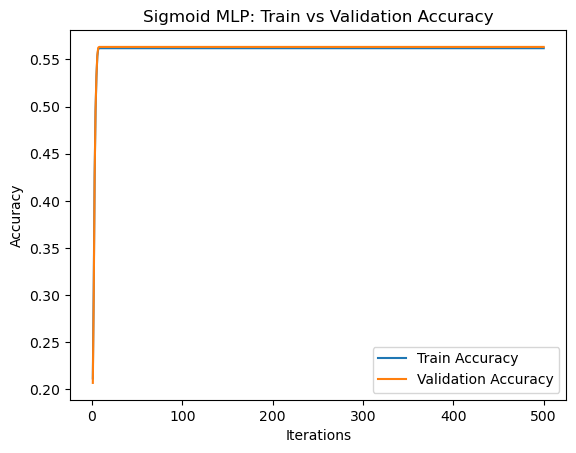

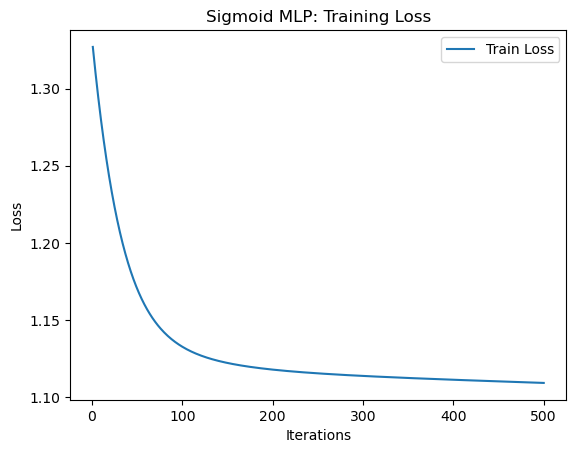

In [10]:
# Plot sigmoid training and validation accuracy plus training loss over iterations.
plt.figure()
plt.plot(range(1, num_iters + 1), train_acc_hist, label="Train Accuracy")
plt.plot(range(1, num_iters + 1), val_acc_hist, label="Validation Accuracy")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.title("Sigmoid MLP: Train vs Validation Accuracy")
plt.legend()
plt.show()

plt.figure()
plt.plot(range(1, num_iters + 1), train_loss_hist, label="Train Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Sigmoid MLP: Training Loss")
plt.legend()
plt.show()

In [11]:
# Run sigmoid inference on aligned test data and print accuracy and classification report.
sigmoid_model.eval()
with torch.no_grad():
    X_test_t = torch.tensor(X_test_eval, dtype=torch.float32).to(device)
    logits_sigmoid = sigmoid_model(X_test_t)
    y_pred_sigmoid = torch.argmax(logits_sigmoid, dim=1).cpu().numpy()

acc_sigmoid = accuracy_score(y_test, y_pred_sigmoid)
print(f"Test Accuracy (TwoHiddenMLP_Sigmoid): {acc_sigmoid:.4f}\n")
print("Classification Report (Sigmoid):")
print(classification_report(y_test, y_pred_sigmoid, digits=4, zero_division=0))

Test Accuracy (TwoHiddenMLP_Sigmoid): 0.5631

Classification Report (Sigmoid):
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       983
           1     0.5631    1.0000    0.7205      4109
           2     0.0000    0.0000    0.0000      1737
           3     0.0000    0.0000    0.0000       468

    accuracy                         0.5631      7297
   macro avg     0.1408    0.2500    0.1801      7297
weighted avg     0.3171    0.5631    0.4057      7297



In [12]:
# Print true and predicted class counts for sigmoid test predictions.
print("True counts:", np.bincount(y_test))
print("Pred counts (Sigmoid):", np.bincount(y_pred_sigmoid))

True counts: [ 983 4109 1737  468]
Pred counts (Sigmoid): [   0 7297]


In [13]:
# Define the ReLU MLP model, initialize parameters, and set loss and optimizer.
class TwoHiddenMLP_ReLU(nn.Module):
    def __init__(self, input_dim, hidden1, hidden2, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.out = nn.Linear(hidden2, num_classes)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        return self.out(x)

@torch.no_grad()
def init_like_numpy_relu(model):
    fan_in_fc1 = model.fc1.weight.shape[1]
    fan_in_fc2 = model.fc2.weight.shape[1]
    fan_in_out = model.out.weight.shape[1]

    model.fc1.weight.normal_(mean=0.0, std=(2.0 / fan_in_fc1) ** 0.5)
    model.fc2.weight.normal_(mean=0.0, std=(2.0 / fan_in_fc2) ** 0.5)
    model.out.weight.normal_(mean=0.0, std=(1.0 / fan_in_out) ** 0.5)

    model.fc1.bias.zero_()
    model.fc2.bias.zero_()
    model.out.bias.zero_()

np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

model2 = TwoHiddenMLP_ReLU(input_dim, hidden1, hidden2, num_classes).to(device)
init_like_numpy_relu(model2)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model2.parameters(), lr=lr)
model2

TwoHiddenMLP_ReLU(
  (fc1): Linear(in_features=12, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (out): Linear(in_features=16, out_features=4, bias=True)
  (act): ReLU()
)

In [14]:
# Train the ReLU model with full-batch gradient descent and track metrics.
train_acc_hist, val_acc_hist, train_loss_hist = [], [], []

for it in range(1, num_iters + 1):
    avg_loss = train_one_iteration_fullbatch(model2, X_tr_t, y_tr_t, optimizer, criterion, device)
    train_acc = accuracy_from_tensors(model2, X_tr_t, y_tr_t, device)
    val_acc = accuracy_from_tensors(model2, X_val_t, y_val_t, device)

    train_loss_hist.append(avg_loss)
    train_acc_hist.append(train_acc)
    val_acc_hist.append(val_acc)

    if it % 20 == 0 or it == 1:
        print(f"Iter {it:3d}/{num_iters} | loss={avg_loss:.4f} | train_acc={train_acc:.4f} | val_acc={val_acc:.4f}")

print("\nFinal Training Accuracy:", train_acc_hist[-1])
print("Final Validation Accuracy:", val_acc_hist[-1])

Iter   1/500 | loss=1.4333 | train_acc=0.1849 | val_acc=0.1809
Iter  20/500 | loss=1.3003 | train_acc=0.3575 | val_acc=0.3561
Iter  40/500 | loss=1.2230 | train_acc=0.5292 | val_acc=0.5329
Iter  60/500 | loss=1.1750 | train_acc=0.5657 | val_acc=0.5643
Iter  80/500 | loss=1.1414 | train_acc=0.5702 | val_acc=0.5686
Iter 100/500 | loss=1.1152 | train_acc=0.5741 | val_acc=0.5729
Iter 120/500 | loss=1.0929 | train_acc=0.5831 | val_acc=0.5825
Iter 140/500 | loss=1.0727 | train_acc=0.6009 | val_acc=0.5981
Iter 160/500 | loss=1.0535 | train_acc=0.6102 | val_acc=0.6093
Iter 180/500 | loss=1.0349 | train_acc=0.6172 | val_acc=0.6177
Iter 200/500 | loss=1.0166 | train_acc=0.6230 | val_acc=0.6233
Iter 220/500 | loss=0.9983 | train_acc=0.6278 | val_acc=0.6276
Iter 240/500 | loss=0.9802 | train_acc=0.6327 | val_acc=0.6334
Iter 260/500 | loss=0.9621 | train_acc=0.6384 | val_acc=0.6377
Iter 280/500 | loss=0.9442 | train_acc=0.6445 | val_acc=0.6450
Iter 300/500 | loss=0.9266 | train_acc=0.6491 | val_acc

In [15]:
# Create a deep-copied ReLU model snapshot for later evaluation and attribution.
relu_model = copy.deepcopy(model2).to(device)

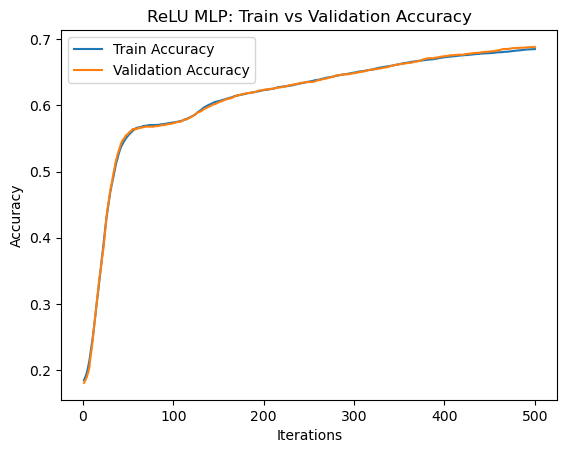

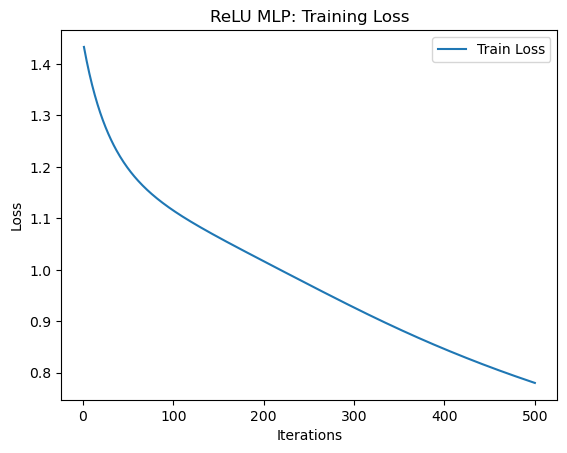

In [16]:
# Plot ReLU training and validation accuracy plus training loss over iterations.
plt.figure()
plt.plot(range(1, num_iters + 1), train_acc_hist, label="Train Accuracy")
plt.plot(range(1, num_iters + 1), val_acc_hist, label="Validation Accuracy")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.title("ReLU MLP: Train vs Validation Accuracy")
plt.legend()
plt.show()

plt.figure()
plt.plot(range(1, num_iters + 1), train_loss_hist, label="Train Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("ReLU MLP: Training Loss")
plt.legend()
plt.show()

In [17]:
# Run ReLU inference on aligned test data and print accuracy and classification report.
relu_model.eval()
with torch.no_grad():
    X_test_t = torch.tensor(X_test_eval, dtype=torch.float32).to(device)
    logits_relu = relu_model(X_test_t)
    y_pred_relu = torch.argmax(logits_relu, dim=1).cpu().numpy()

acc_relu = accuracy_score(y_test, y_pred_relu)
print(f"Test Accuracy (TwoHiddenMLP_ReLU): {acc_relu:.4f}\n")
print("Classification Report (ReLU):")
print(classification_report(y_test, y_pred_relu, digits=4, zero_division=0))

Test Accuracy (TwoHiddenMLP_ReLU): 0.4739

Classification Report (ReLU):
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       983
           1     0.5674    0.6844    0.6204      4109
           2     0.2760    0.3719    0.3168      1737
           3     0.0000    0.0000    0.0000       468

    accuracy                         0.4739      7297
   macro avg     0.2108    0.2641    0.2343      7297
weighted avg     0.3852    0.4739    0.4248      7297



In [18]:
# Print true and predicted class counts for ReLU test predictions.
print("True counts:", np.bincount(y_test))
print("Pred counts (ReLU):", np.bincount(y_pred_relu))

True counts: [ 983 4109 1737  468]
Pred counts (ReLU): [   0 4956 2341]


In [20]:
# Define input-sensitivity attribution helpers and feature ranking utilities.
X_attr = X_test_eval if "X_test_eval" in globals() else X_test
if "X_test_eval_df" in globals():
    feat_names_attr = np.array(X_test_eval_df.columns.tolist())
else:
    feat_names_attr = np.array(X_train_df.columns.tolist())

def input_sensitivity_attribution(model, X_np, batch_size=512, target_mode="pred", y_target=None, device=device):
    
    model.eval()
    all_abs_grads, all_preds, all_targets = [], [], []
    n = X_np.shape[0]

    for start in range(0, n, batch_size):
        end = min(start + batch_size, n)

        xb = torch.tensor(X_np[start:end], dtype=torch.float32, device=device, requires_grad=True)
        logits = model(xb)
        preds = logits.argmax(dim=1)

        if target_mode == "pred":
            target = preds
        elif target_mode == "true":
            if y_target is None:
                raise ValueError("y_target is required when target_mode='true'")
            target = torch.tensor(y_target[start:end], dtype=torch.long, device=device)
        else:
            raise ValueError("target_mode must be 'pred' or 'true'")

        score = logits.gather(1, target.view(-1, 1)).sum()

        model.zero_grad(set_to_none=True)
        if xb.grad is not None:
            xb.grad.zero_()
        score.backward()

        abs_grads = xb.grad.detach().abs()

        all_abs_grads.append(abs_grads.cpu())
        all_preds.append(preds.detach().cpu())
        all_targets.append(target.detach().cpu())

    return (
        torch.cat(all_abs_grads, dim=0).numpy(),
        torch.cat(all_preds, dim=0).numpy(),
        torch.cat(all_targets, dim=0).numpy(),
    )

def rank_features_from_abs_grads(abs_grads, feature_names):
    global_importance = abs_grads.mean(axis=0)
    ranked = (
        pd.DataFrame({"feature": feature_names, "importance": global_importance})
        .sort_values("importance", ascending=False)
        .reset_index(drop=True)
    )
    return ranked

def classwise_rankings(abs_grads, class_ids, feature_names, top_k=10):
    rows = []
    for c in np.unique(class_ids):
        mask = (class_ids == c)
        if mask.sum() == 0:
            continue
        imp_c = abs_grads[mask].mean(axis=0)
        top_idx = np.argsort(imp_c)[::-1][:top_k]
        for r, idx in enumerate(top_idx, start=1):
            rows.append({
                "class": int(c),
                "rank": r,
                "feature": feature_names[idx],
                "importance": float(imp_c[idx]),
            })
    return pd.DataFrame(rows)

In [21]:
# Compute and print global influential features from sigmoid input-sensitivity attribution.
abs_grads_sigmoid, preds_sigmoid, targets_sigmoid = input_sensitivity_attribution(
    model=sigmoid_model,
    X_np=X_attr,
    batch_size=512,
    target_mode="pred",
    device=device
)

ranked_sigmoid = rank_features_from_abs_grads(abs_grads_sigmoid, feat_names_attr)
print("Top influential input features (Sigmoid):")
print(ranked_sigmoid.to_string(index=False))

Top influential input features (Sigmoid):
                          feature  importance
           room_type_Private room    0.025599
                   minimum_nights    0.022819
            room_type_Shared room    0.018768
neighbourhood_group_Staten Island    0.013613
    neighbourhood_group_Manhattan    0.011998
       neighbourhood_group_Queens    0.011835
                    amenity_score    0.008400
        neighbourhood_group_Bronx    0.006204
        room_type_Entire home/apt    0.005046
                 availability_365    0.003796
                number_of_reviews    0.003202
     neighbourhood_group_Brooklyn    0.002616


In [22]:
# Compute and print global influential features from ReLU input-sensitivity attribution.
abs_grads_relu, preds_relu, targets_relu = input_sensitivity_attribution(
    model=relu_model,
    X_np=X_attr,
    batch_size=512,
    target_mode="pred",
    device=device
)

ranked_relu = rank_features_from_abs_grads(abs_grads_relu, feat_names_attr)
print("Top influential input features (ReLU):")
print(ranked_relu.to_string(index=False))

Top influential input features (ReLU):
                          feature  importance
           room_type_Private room    0.734979
                    amenity_score    0.540007
neighbourhood_group_Staten Island    0.300575
                number_of_reviews    0.298316
       neighbourhood_group_Queens    0.263766
     neighbourhood_group_Brooklyn    0.244181
            room_type_Shared room    0.234732
                   minimum_nights    0.228418
        room_type_Entire home/apt    0.200219
    neighbourhood_group_Manhattan    0.166163
                 availability_365    0.154373
        neighbourhood_group_Bronx    0.152949
